# Simple 2 Moving Average Model

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import date, timedelta

Downloading Data:

In [2]:
#all inputs
ticker = "QQQ"
#YYYY-MM-DD
start = "2015-04-25"
#moving Averages, MA1 is typically smaller than MA2
MA1 = "50"
MA2 = "250"

#model trading days input in days, standard 1Y is 252 days. Can use multiples of 252 to track years
model_days = 252 * 1


#fixed end date of today - 1 day
end = str(date.today() - timedelta(1))

#multi_level_index = False removes ticker noise in table
df = yf.download(ticker, start, end, multi_level_index = False)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


# Complete Table Creation

In [3]:
#adding day count
day_count = np.arange(1, len(df) + 1)
df['Day Count'] = day_count

#dropping volume column
df.drop(columns=['Volume'], inplace = True)

Adding MAs:

In [4]:
df[f'{MA1}-day MA'] = df['Close'].rolling(int(MA1)).mean().shift()
df[f'{MA2}-day MA'] = df['Close'].rolling(int(MA2)).mean().shift()
#we .shift() to push the moving average forward a day because the moving average cannot start until x days have finished

Adding Signals:

In [5]:
#signal to long
df['Signal'] = np.where(df[f'{MA1}-day MA'] > df[f'{MA2}-day MA'], 1, 0)

#signal to short
df['Signal'] = np.where(df[f'{MA1}-day MA'] < df[f'{MA2}-day MA'], -1, df['Signal'])

Returns:

In [6]:
#create returns and the model returns colummns
# the difference between the current row ln and previous row ln gives a daily return
df['Daily Return'] = (np.log(df['Close']).diff()) * 100

# model return, if our signal is - we are short and the daily return is negative. vice versa
df['Model Return'] = df['Daily Return'] * df['Signal']

#entry column for visualization
df['Entry'] = df.Signal.diff()
df.dropna(inplace=True)

In [7]:
#Cumulative Returns
df['Cumulative Return'] = (np.exp(df['Daily Return'] / 100).cumprod() - 1) * 100
df['Cumulative Model Return'] = (np.exp(df['Model Return'] / 100).cumprod() - 1) * 100

#formatting the table
df = round((df[['Day Count', 'Open', 'High', 'Low', 'Close', f'{MA1}-day MA', f'{MA2}-day MA', 'Daily Return', 'Cumulative Return', 'Model Return', 'Cumulative Model Return', 'Signal', 'Entry']]), 3)
df

,Day Count,Open,High,Low,Close,50-day MA,250-day MA,Daily Return,Cumulative Return,Model Return,Cumulative Model Return,Signal,Entry
Date,,,,,,,,,,,,,
2016-04-22,251,102.241,102.719,101.221,102.026,99.352,100.604,-1.521,-1.509,1.521,1.532,-1,-1.0
2016-04-25,252,101.717,102.035,101.530,102.026,99.588,100.604,0.000,-1.509,-0.000,1.532,-1,0.0
2016-04-26,253,102.241,102.410,101.221,101.530,99.826,100.604,-0.488,-1.988,0.488,2.029,-1,0.0
2016-04-27,254,100.491,100.949,99.882,100.715,100.027,100.605,-0.805,-2.775,0.805,2.854,-1,0.0
2016-04-28,255,100.828,101.417,99.302,99.498,100.170,100.609,-1.216,-3.949,1.216,4.112,-1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-16,2510,449.030,452.620,437.760,444.180,490.221,482.978,-3.062,328.789,-3.062,354.443,1,0.0
2025-04-17,2511,447.170,447.750,441.360,444.100,488.631,483.062,-0.018,328.712,-0.018,354.361,1,0.0
2025-04-21,2512,438.230,439.080,427.930,433.110,486.992,483.155,-2.506,318.102,-2.506,343.118,1,0.0


# MA Cross-Over Grid Visualization

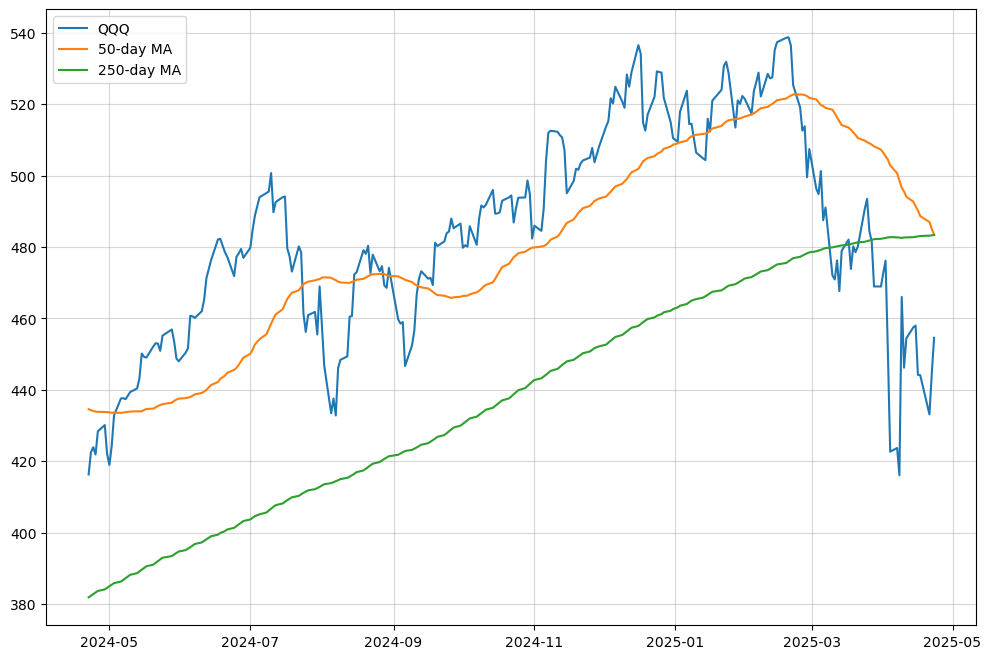

In [8]:
def gen_visual():
#parameters for grid size
    plt.rcParams['figure.figsize'] = 12, 8
#create grid
    plt.grid(True, alpha = .5)
#plot ticker closing prices and MAs, .iloc for integers
    plt.plot(df.iloc[-model_days:]['Close'], label = f'{ticker.upper()}')
    plt.plot(df.iloc[-model_days:][f'{MA1}-day MA'], label = f'{MA1}-day MA')
    plt.plot(df.iloc[-model_days:][f'{MA2}-day MA'], label = f'{MA2}-day MA')
#plotting entry points, .loc for labels
    plt.plot(df[-model_days:].loc[df.Entry == 2].index, df[-model_days:][f'{MA1}-day MA'][df.Entry == 2], '^', color = 'g', markersize = 10)
    plt.plot(df[-model_days:].loc[df.Entry == -2].index, df[-model_days:][f'{MA2}-day MA'][df.Entry == -2], 'v', color = 'r', markersize = 10)
#plot legend
    plt.legend(loc=2)
gen_visual()

# Buy/Hold to SMA Returns Comparison

Cumulative Buy/Hold Return: 338.81
Cumulative Model Return: 365.06


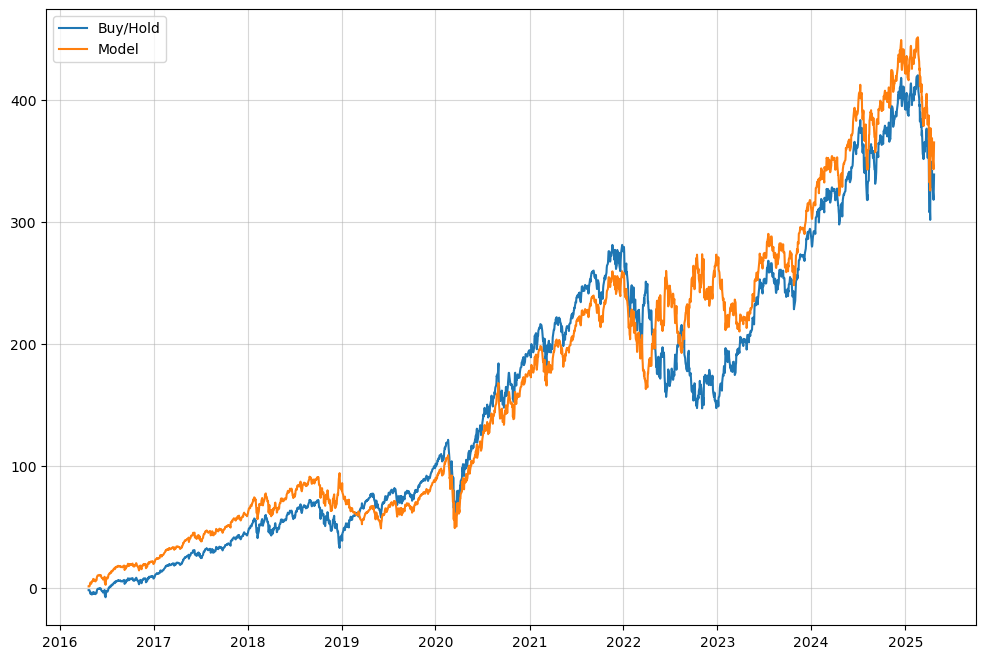

In [9]:
def gen_buyhold_comp():
#buy/hold plot
    plt.plot(df['Cumulative Return'], label='Buy/Hold')
#model plot
    plt.plot(df['Cumulative Model Return'], label='Model')
    plt.legend(loc=2)
    plt.grid(True, alpha=.5)
#print returns
    print("Cumulative Buy/Hold Return:", round(df['Cumulative Return'].iloc[-1], 2))
    print("Cumulative Model Return:", round(df['Cumulative Model Return'].iloc[-1], 2))
gen_buyhold_comp()

# Sharpe Ratio:

In [10]:
def gen_sharpe(returns):
    avg_r = float((np.mean(returns)))
    std = float((np.std(returns)))
    sharpe = (avg_r / std) * 252 ** 0.5
    return sharpe
print('Buy/Hold Sharpe Ratio:', round(gen_sharpe(df['Daily Return']), 2))
print('Model Sharpe Ratio:', round(gen_sharpe(df['Model Return']), 2))

Buy/Hold Sharpe Ratio: 0.72
Model Sharpe Ratio: 0.75
